In [29]:
# %matplotlib inline
from __future__ import print_function

import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics
import pandas as pd
from sklearn.model_selection import train_test_split


# Classification of text documents using sparse features


This is an example showing how scikit-learn can be used to classify documents
by topics using a bag-of-words approach. This example uses a scipy.sparse
matrix to store the features and demonstrates various classifiers that can
efficiently handle sparse matrices.

The dataset used in this example is the 20 newsgroups dataset. It will be
automatically downloaded, then cached.

The bar plot indicates the accuracy, training time (normalized) and test time
(normalized) of each classifier.




Automatically created module for IPython interactive environment
Usage: ipykernel_launcher.py [options]

Options:
  -h, --help            show this help message and exit
  --report              Print a detailed classification report.
  --chi2_select=SELECT_CHI2
                        Select some number of features using a chi-squared
                        test
  --confusion_matrix    Print the confusion matrix.
  --top10               Print ten most discriminative terms per class for
                        every classifier.
  --all_categories      Whether to use all categories or not.
  --use_hashing         Use a hashing vectorizer.
  --n_features=N_FEATURES
                        n_features when using the hashing vectorizer.
  --filtered            Remove newsgroup information that is easily overfit:
                        headers, signatures, and quoting.

Loading 20 newsgroups dataset for categories:
['POLITICS', 'HEALTH', 'LAW/ORDER', 'RELIGION', 'FARMING', 'WILDLIFE/ENVIRON

C:\Users\amakr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:263: RuntimeWarning: invalid value encountered in true_divide


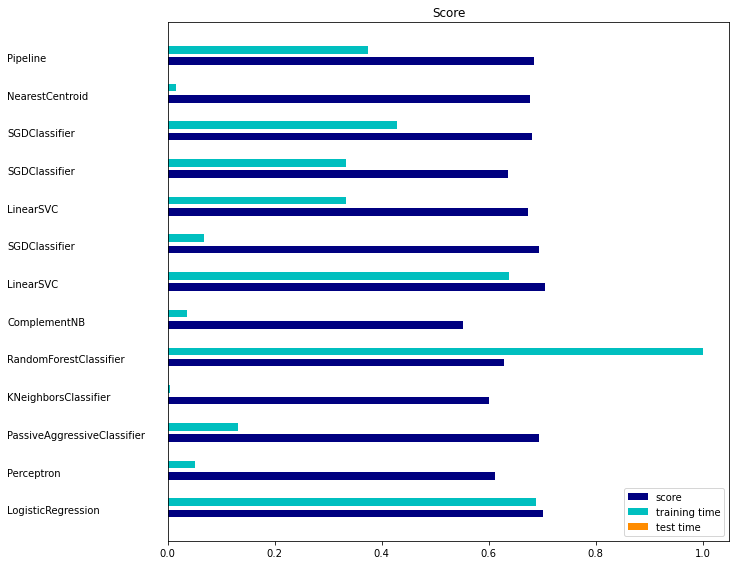

In [33]:
# Author: Peter Prettenhofer <pet
from sklearn.decomposition import PCA

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')


# parse commandline arguments
op = OptionParser()
op.add_option("--report",
              action="store_true", dest="print_report",
              help="Print a detailed classification report.")
op.add_option("--chi2_select",
              action="store", type="int", dest="select_chi2",
              help="Select some number of features using a chi-squared test")
op.add_option("--confusion_matrix",
              action="store_true", dest="print_cm",
              help="Print the confusion matrix.")
op.add_option("--top10",
              action="store_true", dest="print_top10",
              help="Print ten most discriminative terms per class"
                   " for every classifier.")
op.add_option("--all_categories",
              action="store_true", dest="all_categories",
              help="Whether to use all categories or not.")
op.add_option("--use_hashing",
              action="store_true",
              help="Use a hashing vectorizer.")
op.add_option("--n_features",
              action="store", type=int, default=2 ** 16,
              help="n_features when using the hashing vectorizer.")
op.add_option("--filtered",
              action="store_true",
              help="Remove newsgroup information that is easily overfit: "
                   "headers, signatures, and quoting.")


def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')

# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)

print(__doc__)
op.print_help()
print()

train = pd.read_csv('../data/Train.csv')
test = pd.read_csv('../data/Test.csv')

# #############################################################################
# Load some categories from the training set
if opts.all_categories:
    categories = None
else:
    categories = train.Label.unique().tolist()

if opts.filtered:
    remove = ('headers', 'footers', 'quotes')
else:
    remove = ()

print("Loading 20 newsgroups dataset for categories:")
print(categories if categories else "all")

# data_train = train
# data_test = test
data_train, data_test = train_test_split(train, test_size=0.2, random_state = 42, stratify = train['Label'])
print('data loaded')

# order of labels in `target_names` can be different from `categories`
target_names = data_train.Label.unique().tolist()


def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6

data_train_size_mb = size_mb(data_train.Text)
data_test_size_mb = size_mb(data_test.Text)

print("%d documents - %0.3fMB (training set)" % (
    len(data_train.Text), data_train_size_mb))
print("%d documents - %0.3fMB (test set)" % (
    len(data_test.Text), data_test_size_mb))
print("%d categories" % len(categories))
print()

# split a training set and a test set
y_train, y_test = data_train.Label, data_test.Label

print("Extracting features from the training data using a sparse vectorizer")
t0 = time()
if opts.use_hashing:
    vectorizer = HashingVectorizer(stop_words='english', alternate_sign=False,
                                   n_features=opts.n_features)
    X_train = vectorizer.transform(data_train.Text)
else:
    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(data_train.Text)
#     pca  = PCA(n_components = 0.995)
#     X_train = pca.fit_transform(X_train.toarray())
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_train_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_train.shape)
print()

print("Extracting features from the test data using the same vectorizer")
t0 = time()
X_test = vectorizer.transform(data_test.Text)
# X_test = pca.transform(X_test.toarray())
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_test_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_test.shape)
print()

# mapping from integer feature name to original token string
if opts.use_hashing:
    feature_names = None
else:
    feature_names = vectorizer.get_feature_names()
# opts.select_chi2 = 5000
if opts.select_chi2:
    print("Extracting %d best features by a chi-squared test" %
          opts.select_chi2)
    t0 = time()
    ch2 = SelectKBest(chi2, k=opts.select_chi2)
    X_train = ch2.fit_transform(X_train, y_train)
    X_test = ch2.transform(X_test)
    if feature_names:
        # keep selected feature names
        feature_names = [feature_names[i] for i
                         in ch2.get_support(indices=True)]
    print("done in %fs" % (time() - t0))
    print()

if feature_names:
    feature_names = np.asarray(feature_names)


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

from sklearn.model_selection import cross_val_score

# #############################################################################
# Benchmark classifiers
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
#     skf = StratifiedKFold(n_splits=5, random_state=0)
#     models, preds = [], []
#     for train, test in skf.split(X_train, y_train):
#     print(train, test)
#     clf = LogisticRegression(penalty='l1')
#         clf.fit(X_train[train], y_train.loc[train])
#         preds.append(clf.predict(X_test))
#         models.append(clf)
#         coefs.append(clf.coef_[0])
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)
    test_00 = vectorizer.transform(test.Text)
#     test_00 = pca.transform(test_00.toarray())
    t0 = time()
#     pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)
    pred = clf.predict(X_test)#pd.DataFrame(preds).mean().values
    score = metrics.accuracy_score(y_test,pred )
    print("accuracy:   %0.3f" % score)
    pred_00 = clf.predict(test_00)
    print(pred_00[1])
    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if opts.print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        print()

    if opts.print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                            target_names=target_names))

    if opts.print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time, clf


results = []
for clf, name in (
        (LogisticRegression(tol=1e-3, solver="liblinear",C = 12), "Logistic Classifier"),
        (Perceptron(), "Perceptron"),
        (PassiveAggressiveClassifier(), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=40), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest"),
        (ComplementNB(), "ComplementNB")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=200,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=200,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
# print("Naive Bayes")
# results.append(benchmark(MultinomialNB(alpha=.01)))
# results.append(benchmark(BernoulliNB(alpha=.01)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(5)]

clf_names, score, training_time, test_time, clfs = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

In [27]:
# y_train.loc[2]
import gc 
gc.collect()

5365

In [67]:
# list(zip(results[0],results[4]))
names = results[0]
names[7] = 'LinearSVC_1'
names[8] = 'SGDClassifier_1'
names[9] = 'SGDClassifier_2'
names


['LogisticRegression',
 'Perceptron',
 'PassiveAggressiveClassifier',
 'KNeighborsClassifier',
 'RandomForestClassifier',
 'LinearSVC',
 'SGDClassifier',
 'LinearSVC_1',
 'SGDClassifier_1',
 'SGDClassifier_2',
 'NearestCentroid',
 'Pipeline']

In [68]:
class_i = list(zip(names,results[4]))
# hasattr(class_i[0][1],'predict_proba')
new_clf=[]
for item in class_i:
    if hasattr(item[1],'predict_proba'):
        new_clf.append(item)

In [69]:
new_clf

[('LogisticRegression',
  LogisticRegression(C=12, solver='liblinear', tol=0.001)),
 ('KNeighborsClassifier', KNeighborsClassifier(n_neighbors=20)),
 ('RandomForestClassifier', RandomForestClassifier())]

In [73]:
from sklearn.ensemble import VotingClassifier,StackingClassifier
voting_clf = VotingClassifier(class_i,voting = 'hard')

In [74]:
# str(clf)
# clf_vote =
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('LogisticRegression',
                              LogisticRegression(C=12, solver='liblinear',
                                                 tol=0.001)),
                             ('Perceptron', Perceptron()),
                             ('PassiveAggressiveClassifier',
                              PassiveAggressiveClassifier()),
                             ('KNeighborsClassifier',
                              KNeighborsClassifier(n_neighbors=20)),
                             ('RandomForestClassifier',
                              RandomForestClassifier()),
                             ('LinearSVC', LinearSVC(dual=False, tol=0....
                              LinearSVC(dual=False, penalty='l1', tol=0.001)),
                             ('SGDClassifier_1',
                              SGDClassifier(max_iter=200, penalty='l1')),
                             ('SGDClassifier_2',
                              SGDClassifier(max_iter=200,
         

In [75]:
voting_clf.score(X_test,y_test)
# class_i[2][1].score(X_test,y_test)
# y_test

0.7083333333333334

In [127]:
# class_i[::2]
X_test_2 = vectorizer.transform(test.Text)

In [137]:
test['Label'] = voting_clf.predict(X_test_2)

In [138]:
sub = test[['ID','Label']]

In [139]:
sub.to_csv('democ.csv', index = False)

In [20]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier
clf_3 =  ExtraTreesClassifier(n_estimators = 10000) #,criterion = 'entropy' 
clf_3.fit(X_train,y_train)

ExtraTreesClassifier(n_estimators=10000)

In [27]:
# clf_3.score(X_test,y_test)
# from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve,auc
# from sklearn.model_selection import GridSearchCV,StratifiedKFold
# logreg = LogisticRegression(class_weight='balanced',multi_class = 'ovr')
# param = {'C':[0.001,0.005,0.01,0.05,0.1,0.5,1,2,3,3,4,5,10,20]}
# clf = GridSearchCV(logreg,param,scoring='accuracy',refit=True,cv=6)
# clf.fit(X_train,y_train)
# print('Best roc_auc: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_))


Best roc_auc: 0.6331, with best C: {'C': 20}


In [31]:
# X_train.toarray().shape
new_train_1 = vectorizer.transform(train.Text).toarray()

In [55]:
# (new_train_1[0] == 0).all()
# new_train_1.shape
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
# exper = np.concatenate((new_train_1, le.fit_transform(train.Label).reshape(-1,1)), axis = 1)

In [56]:
# le.fit_transform(train.Label).shape

In [59]:
pca = PCA(n_components = 0.99)

In [60]:
exper_train = pca.fit_transform(new_train_1)

In [62]:
# type(exper)
# exper
exper_train.shape

(1436, 1389)

In [98]:
X_train.iloc[0]

AttributeError: iloc not found

In [1]:
import os

In [77]:
import pandas as pd
import glob
files = glob.glob("C:/Users/amakr/Downloads/*.csv")

df = pd.DataFrame()
for f in files:
    csv = pd.read_csv(f)
    df.append(csv)

In [78]:
i = 0

In [127]:

csv = pd.read_csv(files[i])
i = i+1
csv

IndexError: list index out of range

In [81]:
files

['C:/Users/amakr/Downloads\\acimcombinedrates.csv',
 'C:/Users/amakr/Downloads\\bbc-text.csv',
 'C:/Users/amakr/Downloads\\CCG_1_20_I01971_D.csv',
 'C:/Users/amakr/Downloads\\NGD_bymonth.csv',
 'C:/Users/amakr/Downloads\\NGD_bymonth10.csv',
 'C:/Users/amakr/Downloads\\NGD_bymonth11.csv',
 'C:/Users/amakr/Downloads\\NGD_bymonth12.csv',
 'C:/Users/amakr/Downloads\\NGD_bymonth13.csv',
 'C:/Users/amakr/Downloads\\NGD_bymonth14.csv',
 'C:/Users/amakr/Downloads\\NGD_bymonth15.csv',
 'C:/Users/amakr/Downloads\\NGD_bymonth16.csv',
 'C:/Users/amakr/Downloads\\NGD_bymonth17.csv',
 'C:/Users/amakr/Downloads\\NGD_bymonth2.csv',
 'C:/Users/amakr/Downloads\\NGD_bymonth3.csv',
 'C:/Users/amakr/Downloads\\NGD_bymonth4.csv',
 'C:/Users/amakr/Downloads\\NGD_bymonth5.csv',
 'C:/Users/amakr/Downloads\\NGD_bymonth6.csv',
 'C:/Users/amakr/Downloads\\NGD_bymonth7.csv',
 'C:/Users/amakr/Downloads\\NGD_bymonth8.csv',
 'C:/Users/amakr/Downloads\\NGD_bymonth9.csv',
 'C:/Users/amakr/Downloads\\SampleSubmission (1